# Лінійна регресія: перенавчання та регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "Відповідь:".

In [40]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом "bikes_rent.csv", в якому щодня записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знакомство с данными

# Завдання 1

Завантажте датасет за допомогою функції pandas.read_csv у змінну df. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [41]:
import pandas as pd

# Завантаження датасету в змінну df
df = pd.read_csv("bikes_rent.csv")

# Виведення перших 5 рядків датасету
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:

* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 – немає свята, 1 – є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура у Цельсіях
* _atemp_: температура по відчуттям у Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є дійсні, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із дійсними, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної **cnt**.

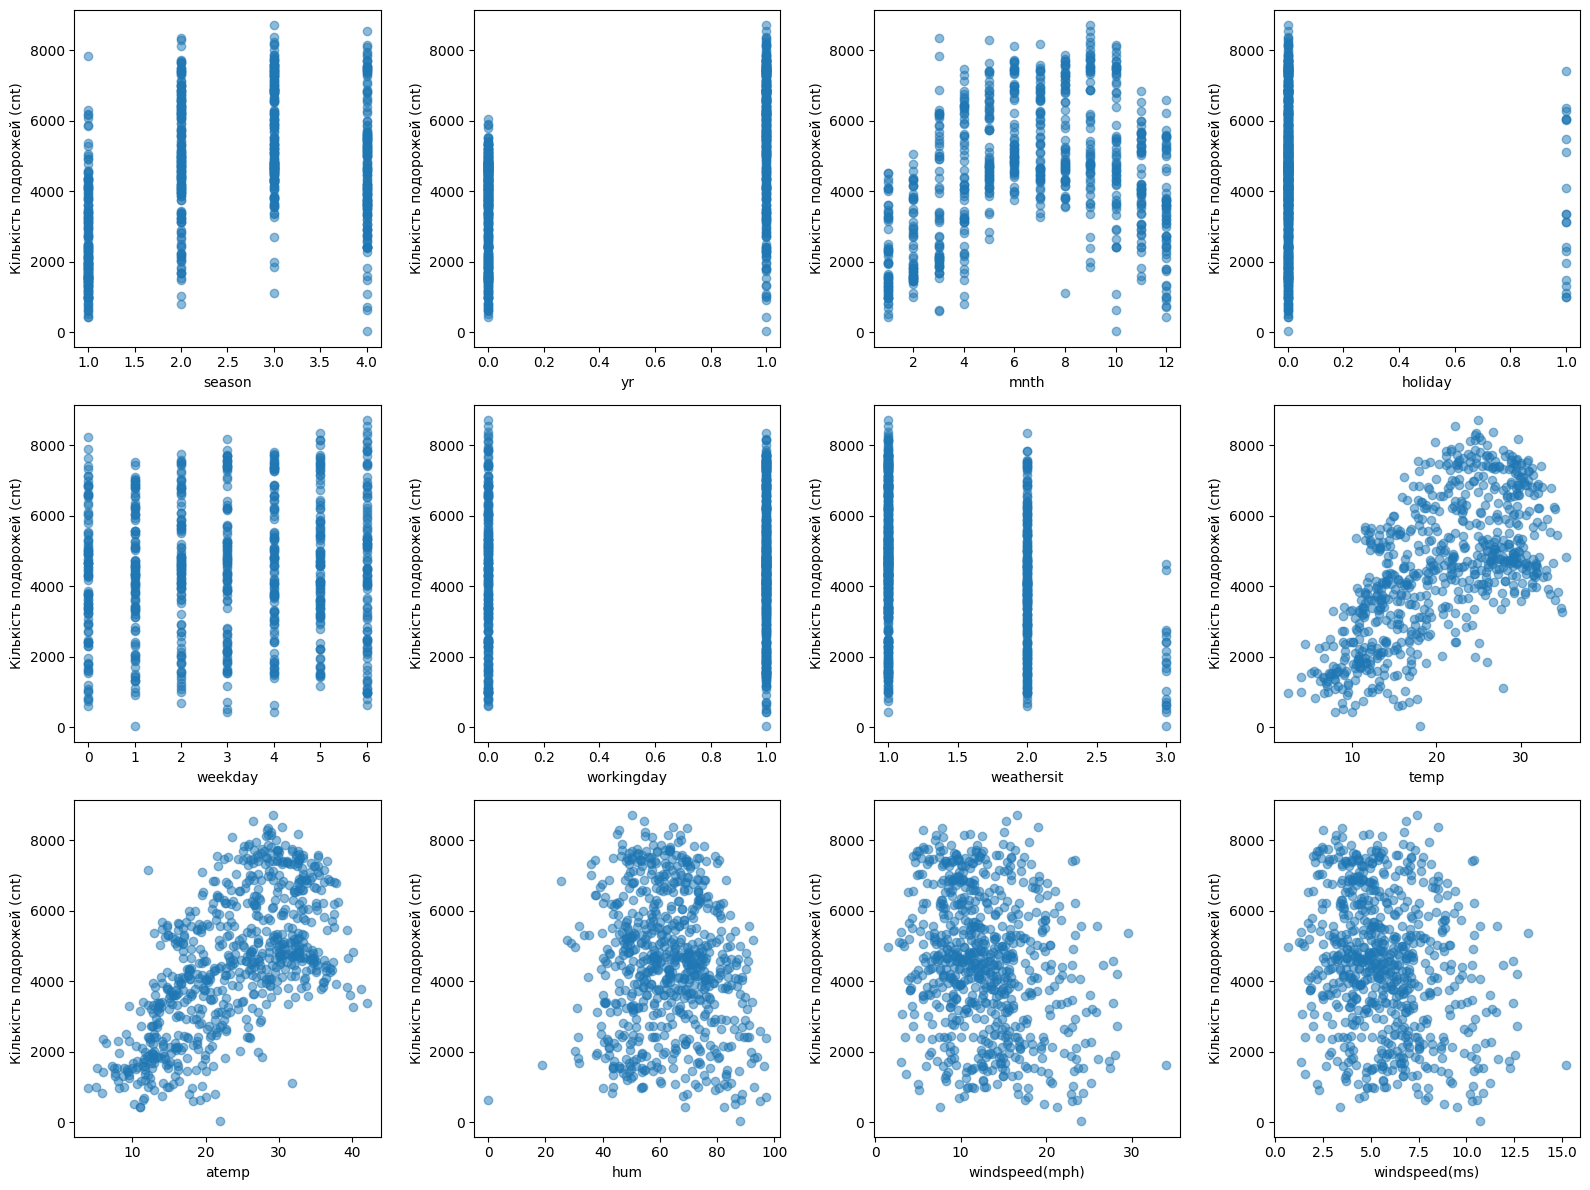

In [42]:
import matplotlib.pyplot as plt
# Список атрибутів для побудови графіків
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Розмір графіків
plt.figure(figsize=(16, 12))

# Побудова графіків для кожного атрибуту
for i, attr in enumerate(attributes, 1):
    plt.subplot(3, 4, i)
    plt.scatter(df[attr], df['cnt'], alpha=0.5)
    plt.xlabel(attr)
    plt.ylabel('Кількість подорожей (cnt)')

# Показати графіки
plt.tight_layout()
plt.show()




Питання:
1. Який характер залежності кількості прокатів від місяця?
1. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно


# Завдання 2

Давайте суворо оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Для її обчислення в pandas можна використовувати методи датафрейму: corr та corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останнім за допомогою методу `corrwith`.

In [43]:
# Визначимо всі ознаки, крім останньої (cnt), і збережемо їх у змінній features
features = df.iloc[:, :-1]

# Останню ознаку (cnt) збережемо у змінній target
target = df['cnt']

# Розрахунок кореляції між ознаками та цільовою змінною (cnt)
correlations = features.corrwith(target)

# Виведемо кореляції для кожної ознаки
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

По графікам видно, деякі ознаки схожі один на одного. Тому давайте також порахуємо кореляції між дійсними ознаками.

# Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt
за допомогою методу corr:

In [44]:
# Ознаки для підрахунку кореляцій
features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Підрахунок попарних кореляцій
correlations = df[features].corr()

# Виведення кореляційної матриці
print(correlations)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


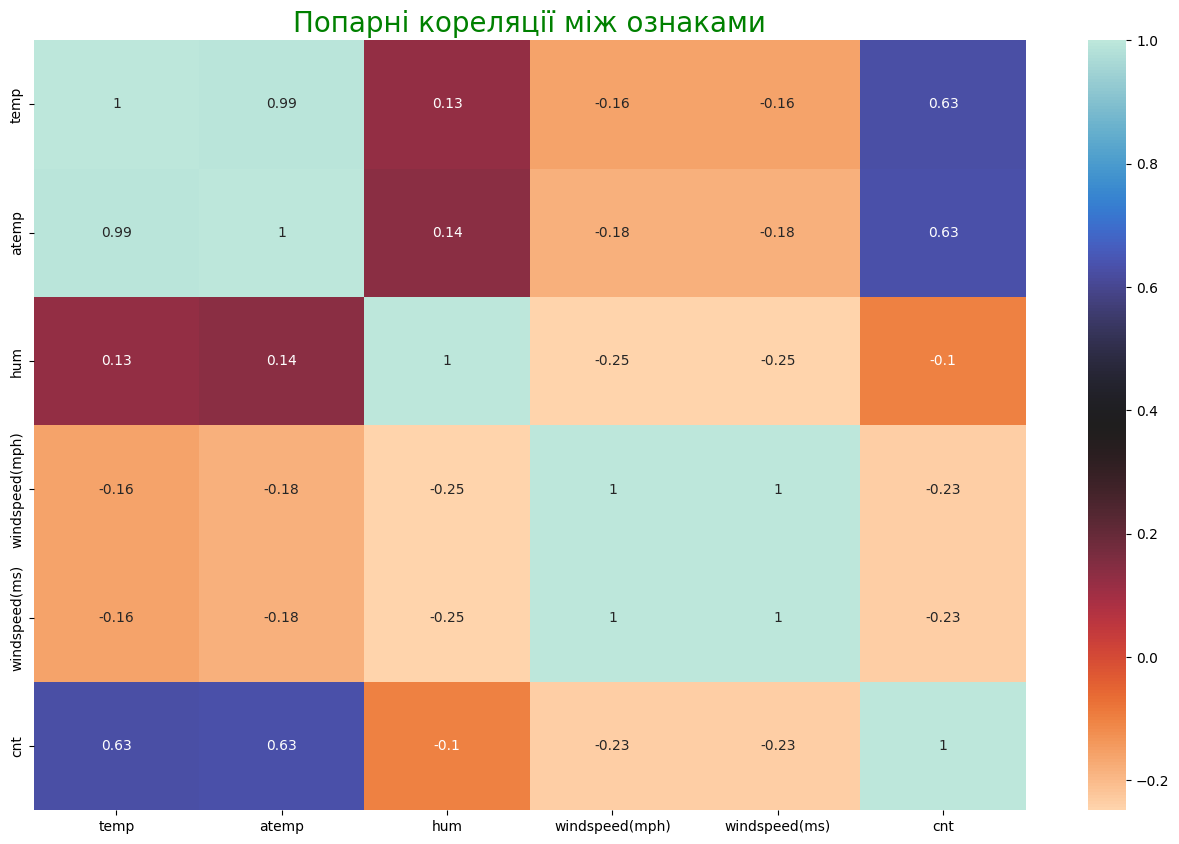

In [45]:
plt.rcParams["figure.figsize"] = (16, 10)
sns.heatmap(df.iloc[:, 7:].corr(), annot=True, cmap='icefire_r')
plt.title('Попарні кореляції між ознаками', fontsize=20, color='g')
plt.show()

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно впливає на навчання лінійної моделі.

# Завдання 4

Виведіть середні ознаки

In [46]:
features_to_normalize = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']
df[features_to_normalize] = (df[features_to_normalize] - df[features_to_normalize].mean()) / df[features_to_normalize].std()

mean_features = df[features_to_normalize].mean()
print("Середні значення ознак після нормалізації:")
print(mean_features)

Середні значення ознак після нормалізації:
season            3.888059e-17
yr               -1.555223e-16
mnth              7.776117e-17
holiday          -5.224579e-17
weekday           2.855293e-17
workingday       -1.540036e-16
weathersit       -2.430037e-17
temp             -9.720147e-17
atemp            -2.527238e-16
hum               3.110447e-16
windspeed(mph)   -1.069216e-16
windspeed(ms)     3.207648e-16
cnt              -7.776117e-17
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо його середнє і поділимо стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це буде потрібно для крос-валідації.

In [47]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [48]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [49]:
from sklearn.linear_model import LinearRegression

# Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються в змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.

In [50]:
reg = LinearRegression().fit(X, y)
[i for i in list(zip(df.columns, reg.coef_))]

[('season', 0.29468311393746394),
 ('yr', 0.5275436178882651),
 ('mnth', -0.0729398657741539),
 ('holiday', -0.04478432315969644),
 ('weekday', 0.07083655544969314),
 ('workingday', 0.029109988566114874),
 ('weathersit', -0.17046438923395438),
 ('temp', 0.18969521697921088),
 ('atemp', 0.30226625359126913),
 ('hum', -0.07516644650313728),
 ('windspeed(mph)', 6429228083.785027),
 ('windspeed(ms)', -6429228083.887471)]

Ми бачимо, що ваги при лінійно-залежних ознаках по модулю значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі у методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим меншим є визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколлінеарності_.

З парою (temp, atemp) трохи менш корелюючих змінних такого не сталося, проте на практиці завжди варто уважно стежити за коефіцієнтами за схожих ознак.

Для того, щоб вирішити проблему мультиколінеарності, потрібно скористатися регуляризатором. До функціонала, що оптимізується, додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

# Завдання 6
Давайте спробуємо навчити лінійні моделі з L_1 і L_2-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за промовчанням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [51]:
from sklearn.linear_model import Lasso, Ridge

In [52]:
lasso = Lasso().fit(X, y)
[i for i in list(zip(df.columns, lasso.coef_))]

[('season', 0.0),
 ('yr', 0.0),
 ('mnth', 0.0),
 ('holiday', -0.0),
 ('weekday', 0.0),
 ('workingday', 0.0),
 ('weathersit', -0.0),
 ('temp', 0.0),
 ('atemp', 0.0),
 ('hum', -0.0),
 ('windspeed(mph)', -0.0),
 ('windspeed(ms)', -0.0)]

Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги

In [53]:
ridge = Ridge().fit(X, y)
[i for i in list(zip(df.columns, ridge.coef_))]

[('season', 0.2906572598368198),
 ('yr', 0.5259871749860238),
 ('mnth', -0.06807378728444041),
 ('holiday', -0.044778848444554556),
 ('weekday', 0.07123905398318789),
 ('workingday', 0.028857515955912353),
 ('weathersit', -0.17156092496839037),
 ('temp', 0.1994918463180669),
 ('atemp', 0.29235169273173284),
 ('hum', -0.07488667650474998),
 ('windspeed(mph)', -0.05123831009720182),
 ('windspeed(ms)', -0.05123831013454787)]

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги в список `coefs_ridge'` Конвертуйте отримані списки в `np.array`.

In [54]:
alphas = np.arange(1, 500, 50)

coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

for index, a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    lasso.fit(X, y)
    coefs_lasso[index] = lasso.coef_

for index, a in enumerate(alphas):
    ridge = Ridge(alpha=a)
    ridge.fit(X, y)
    coefs_ridge[index] = ridge.coef_

Проаналізуйте динаміку ваги при збільшенні параметра регуляризації:

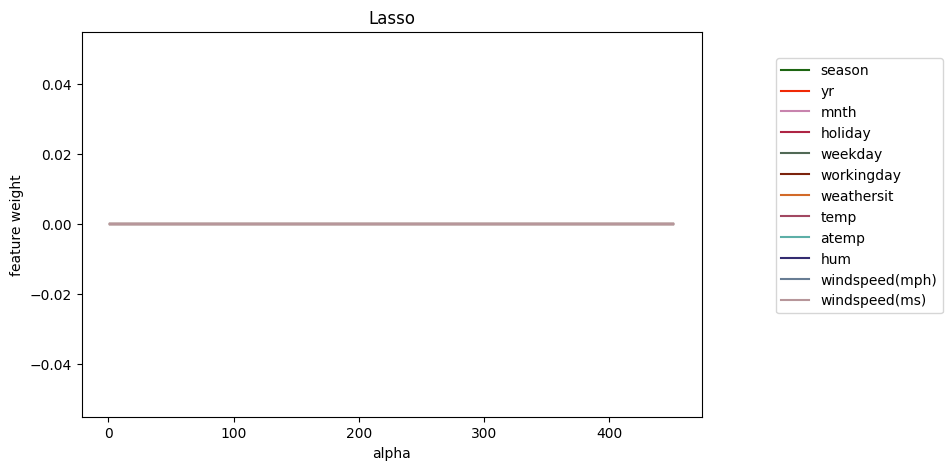

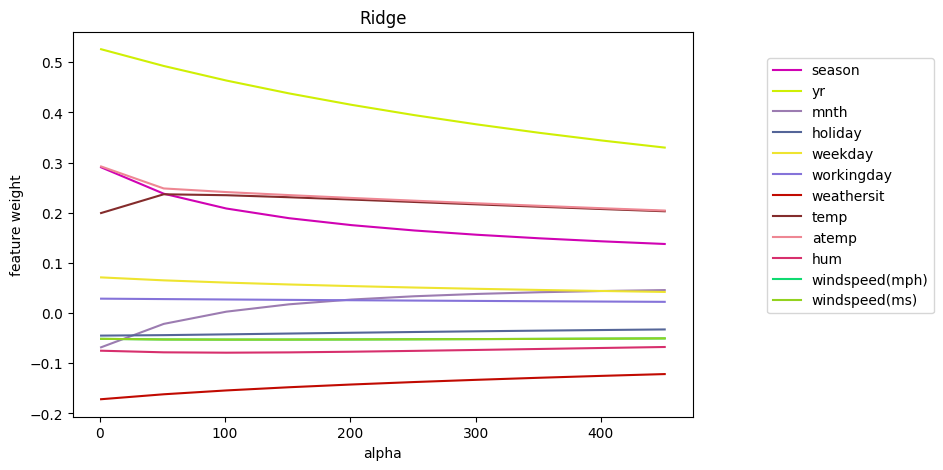

In [55]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповіді:
1.
2.
3.
4.


### Завдання 8

Далі працюватимемо з `Lasso`.

Отже, бачимо, що з зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонал методу найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не …анія на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиття вибірки, на кожному пробувати різні значення alpha, а потім усереднити MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ часто, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а coef\_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [56]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

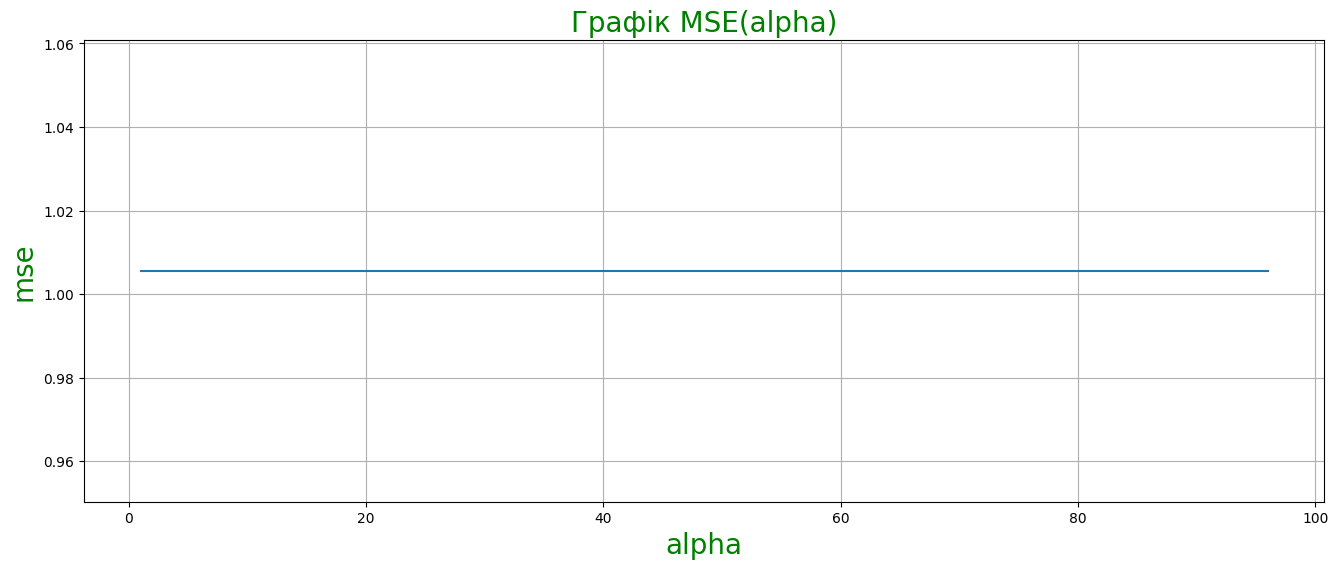

Alpha = 96


[('season', 0.0),
 ('yr', 0.0),
 ('mnth', 0.0),
 ('holiday', -0.0),
 ('weekday', 0.0),
 ('workingday', 0.0),
 ('weathersit', -0.0),
 ('temp', 0.0),
 ('atemp', 0.0),
 ('hum', -0.0),
 ('windspeed(mph)', -0.0),
 ('windspeed(ms)', -0.0)]

In [57]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor =  LassoCV(alphas=alphas).fit(X, y)

mse = [i.mean() for i in regressor.mse_path_]

plt.rcParams["figure.figsize"] = (16, 6)
plt.plot(regressor.alphas_, mse)
plt.title('Графік MSE(alpha)', fontsize=20, color='g')
plt.xlabel("alpha", fontsize=20, color='g')
plt.ylabel("mse", fontsize=20, color='g')
plt.grid()
plt.show()

print(f'Alpha = {regressor.alpha_}')
[i for i in list(zip(df.columns, regressor.coef_))]

Отже, ми вибрали певний параметр регулювання. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбиття (тобто по стовпцях).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.

Alpha = 96, MSE = 1.0896385949775296
Alpha = 96, MSE = 0.9710285931199722
Alpha = 96, MSE = 1.0210537478842785
Alpha = 96, MSE = 0.8970658597436997
Alpha = 96, MSE = 1.0491716221698262


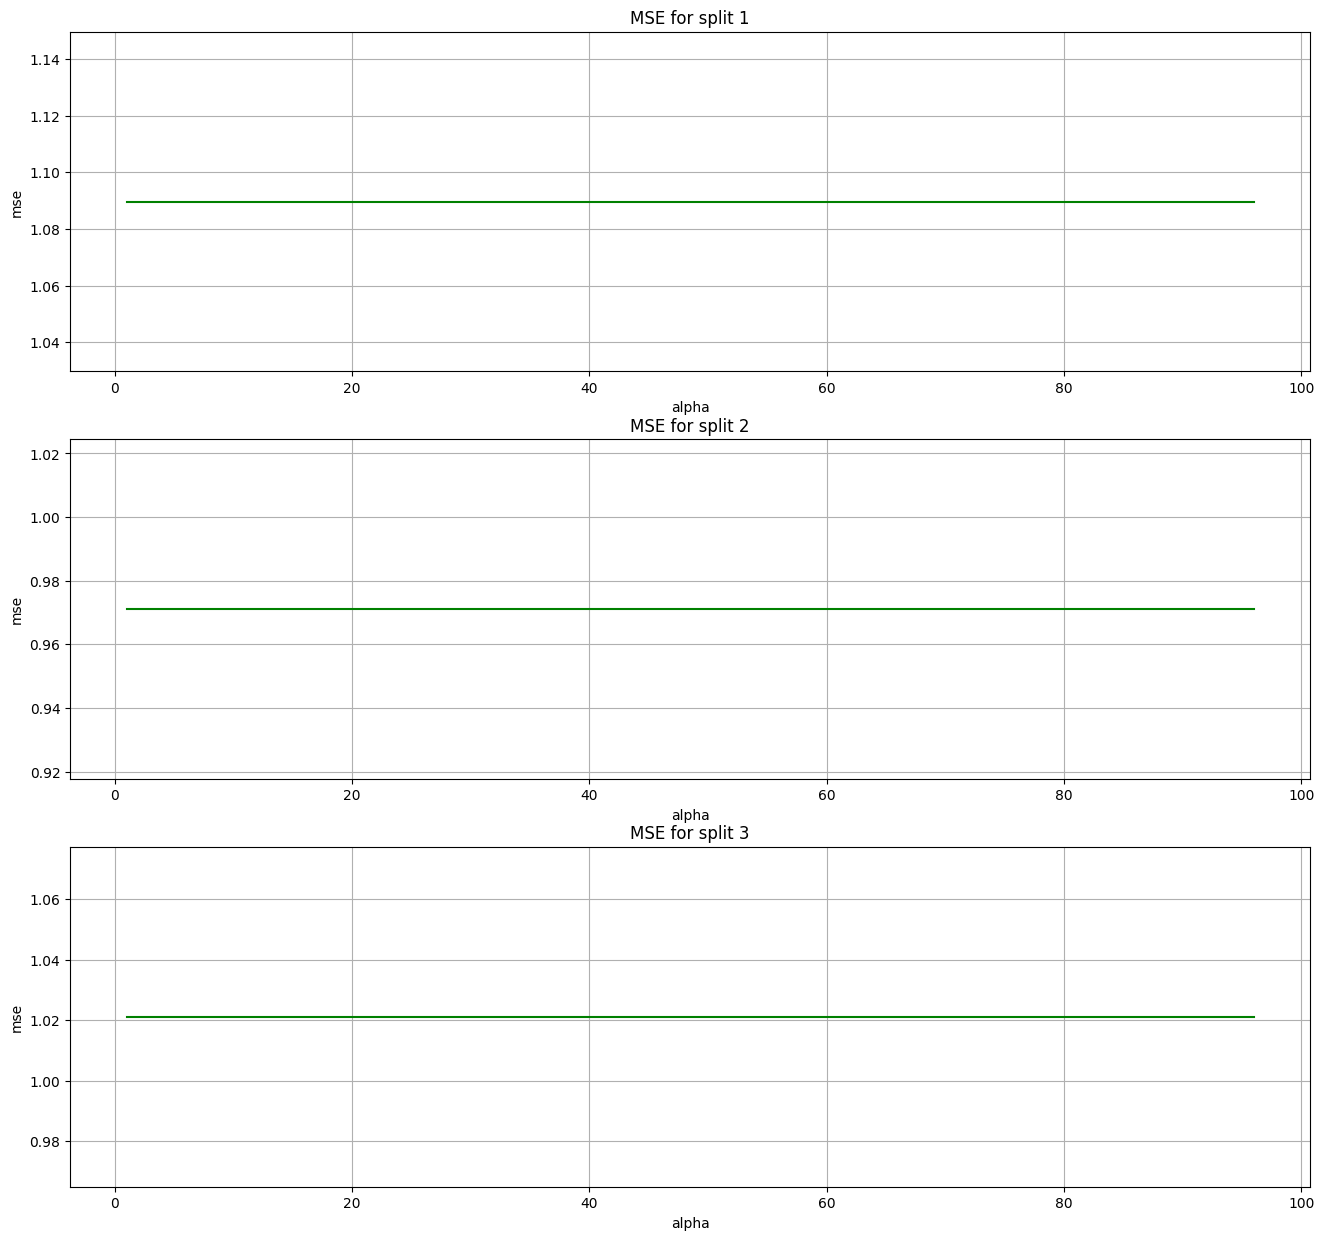

In [58]:
for i in range(3):
    plt.rcParams["figure.figsize"] = (16, 15)
    plt.subplot(3, 1, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], c='g')
    plt.title(f'MSE for split {i+1}')
    plt.xlabel('alpha')
    plt.ylabel('mse')
    plt.grid()

for alpha, mse in enumerate(np.min(regressor.mse_path_, axis=0)):
    alpha_min = regressor.mse_path_[:, alpha].argmin(axis=0)
    print(f'Alpha = {regressor.alphas_[alpha_min]}, MSE = {mse}')

На кожному розбиття оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиття. Виходить, що ми налаштовуємось на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиття вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на наступні запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Відповідь:
1. Так, видно зростаючу лінійну залежність cnt від цих ознак за графіками. 4 ознаки з найбільшими позитивними коефіцієнтами: season,atemp,yr,windspeed(mph)
2.Зовсім ні.За atemp = 100 ніхто не захоче кататися на велосипеді, бо це занадто жарка погода також при windspeed(mph) = 200 ніхто не захоче кататися на велосипеді. yr = 3000 не гарантує нам найбільшого значення cnt, так як все розвивається.

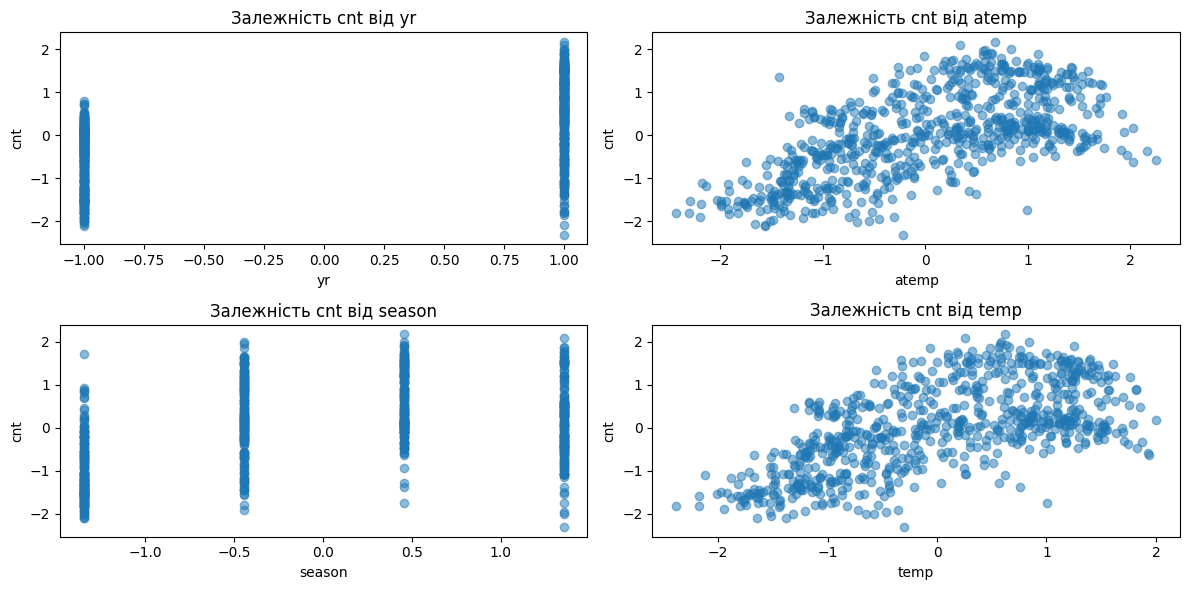

In [59]:
import matplotlib.pyplot as plt
features = ['yr', 'atemp', 'season', 'temp']
coefficients = [1019.46, 576.53, 560.24, 376.36]

plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(2, 2, i + 1)
    plt.scatter(df[feature], df['cnt'], alpha=0.5)
    plt.title(f'Залежність cnt від {feature}')
    plt.xlabel(feature)
    plt.ylabel('cnt')

plt.tight_layout()
plt.show()

#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться відповідні візуалізації. Чи видно лінійну залежність, яка зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

Відповідь:
1. Негативні коефіцієнти означають, що зі зростанням значення цих ознак кількість прокатів (cnt) зменшується
а) Working day: Негативний коефіцієнт (-12.01) означає, що у дні, коли ця ознака дорівнює 0 (неробочий день), буде менше прокатів.

2. Season: Негативний коефіцієнт (-16.64) зображує, що взимку очікується менше прокатів. Погода та температура на вулиці не сприятливі для велосипедних прогулянок для більшості людей.

3. Weekday: Позитивний коефіцієнт (26.07) показує що в дні з більшим значенням є вірогідність отримат більшу кількість прокатів. Можливо,у будні дні люди частіше їздять на велосипедах (робота, магазин, навчання).

# Отримання коефіцієнтів моделі
coefficients = reg.coef_

# Знайдення індексів 3 ознак з найбільшими за модулем негативними коефіцієнтами
top_3_indices = np.argsort(np.abs(coefficients))[:3]

# Виведення назв цих ознак та їх коефіцієнтів
top_3_features = df.columns[top_3_indices]
top_3_coefficients = coefficients[top_3_indices]

print("3 ознаки з найбільшими за модулем негативними коефіцієнтами:")
for feature, coefficient in zip(top_3_features, top_3_coefficients):
    print(f"{feature}: {coefficient}")

#### Питання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви вважаєте, чому модель виключила їх із моделі (знов подивіться на графіки)? Чи правда, що вони не впливають на попит на велосипеди?

Відповідь:
1. Модель виключила їх із моделі, через низький вплив на попит на велосипеди.
2. Правда. Вони не впливають на попит велосипедів. Ці ознаки мають занижений вплив на попит на велосипеди відносно інших ознак.

In [62]:
# Отримання коефіцієнтів моделі
coefficients = reg.coef_

# Знайдення індексів 3 ознак з найбільшими за модулем негативними коефіцієнтами
top_3_indices = np.argsort(np.abs(coefficients))[:3]

# Виведення назв цих ознак та їх коефіцієнтів
top_3_features = df.columns[top_3_indices]
top_3_coefficients = coefficients[top_3_indices]

print("3 ознаки з найбільшими за модулем негативними коефіцієнтами:")
for feature, coefficient in zip(top_3_features, top_3_coefficients):
    print(f"{feature}: {coefficient}")

3 ознаки з найбільшими за модулем негативними коефіцієнтами:
workingday: 0.029109988566114874
holiday: -0.04478432315969644
weekday: 0.07083655544969314


### Висновок
У практичній роботі номер 5 я діналася та навчилась застосовувати на практиці основи регресійного аналізу та регуляризації на прикладі прогнозування кількості орендованих велосипедів.

Завдяки **регресійному аналізу** можливо передбачити числові значення на основі інших ознак. На практиці я дізналася методику побудови та аналізу оцінки регресійної моделі.

За допомогою **регуляризації** є можливість контролювати перенавчання та покращувати якість моделі шляхом обмеження значень коефіцієнтів. Я дізналась про два основних методи регуляризації - Lasso (L1-регуляризація) та Ridge (L2-регуляризація).

Через **візуалізацію залежностей** (побудові графіки для аналізу залежностей між різними атрибутами та цільовою ознакою), є змога визначити, які ознаки мають найбільший вплив на результати моделі.

Практичні вправи допомогли мені надійно зафіксувати нові знання та здобуті навички.

Дякую!  :)